In [1]:
#clear memory
from keras.backend import set_session
from keras.backend import clear_session
from keras.backend import get_session
import tensorflow as tf
import gc
 
# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()
 
    try:
        del classifier # this is from global space - change this as you need
    except:
        pass
 
    print(gc.collect()) # if it does something you should see a number as output
 
    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tf.compat.v1.Session(config=config))


In [2]:
reset_keras()

22


In [3]:
train_root = r'D:\Program Files (x86)\pythonProject\python文件\南洋理工\WEEK3\3-1\Alzheimer_s Dataset\train'
test_root = r'D:\Program Files (x86)\pythonProject\python文件\南洋理工\WEEK3\3-1\Alzheimer_s Dataset\test'

In [4]:
# parameter initialization
dim = (176,208)                            

In [5]:
from skimage import io
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, LeakyReLU,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.callbacks import TensorBoard
import pickle
from PIL import Image
import time
import os
from PIL import Image
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from keras import regularizers

In [6]:

def data_loader_5000(train_root,test_root):
    
    #Set parameters for data generation
    zoom = [.99,1.01]             
    bright_range = [.8,1.2]                               
    momentum = .9   
    
    train_dr = ImageDataGenerator(rescale=1./255,fill_mode='constant',cval=0,
                                                               brightness_range=bright_range,zoom_range=zoom,
                                                               data_format='channels_last',zca_whitening=False)

    train_data_gen = train_dr.flow_from_directory(directory=train_root,target_size=dim,
                                                  batch_size=5000)

    test_dr = ImageDataGenerator(rescale=1./255,fill_mode='constant',cval=0,zoom_range=[1,1],
                                                              data_format='channels_last') 

    test_data_gen = test_dr.flow_from_directory(directory=test_root,target_size=dim,batch_size=5000,
                                               shuffle = False) 

    # Set parameters to segment the dataset
    test_split_percent = .1       
    validation_split_percent = .2 

    train_data,train_labels =  train_data_gen.next()
    test_data,test_labels = test_data_gen.next()
    total_data = np.concatenate((train_data,test_data))
    total_labels = np.concatenate((train_labels,test_labels))

    initial_split = test_split_percent+validation_split_percent
    test_val_split = test_split_percent/initial_split

    train_data, test_val_data, train_labels, test_val_labels = train_test_split(total_data,total_labels,
                                                                                test_size=initial_split)

    test_data, val_data, test_labels, val_labels = train_test_split(test_val_data,test_val_labels,
                                                                    test_size=test_val_split)
    
    return  train_data ,train_labels, test_data, val_data, test_labels, val_labels


In [7]:
from sklearn.metrics import accuracy_score, average_precision_score,precision_score,f1_score,recall_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,LearningRateScheduler,ReduceLROnPlateau
import math

earlyStopping = EarlyStopping(
    monitor='val_accuracy', patience=8, verbose=1, mode='max', restore_best_weights=True)

reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
                           patience=5, verbose=1, mode='max', cooldown=1, min_lr=1e-8)

callback_list = [earlyStopping, reduce]

#Set the callback function for subsequent training

In [8]:
#set optimizer
# opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum, nesterov=True,name='SGD') 
adam=tf.keras.optimizers.Adam(learning_rate=0.001)

In [17]:
def get_result(model_history,vg_model,test_data, test_labels):
    
    #First intuitively calculate the accuracy
    test_scores = vg_model.evaluate(test_data, test_labels)
    print('Test Accuracy: %.2f%%'%(test_scores[1]*100))
    
    # Visualize the training process
    fig, ax = plt.subplots(1, 2, figsize = (30, 5))
    ax = ax.ravel()

    for i, metric in enumerate(["accuracy", "loss"]):
        ax[i].plot(model_history.history[metric])
        ax[i].plot(model_history.history["val_" + metric])
        ax[i].set_title("Model {}".format(metric))
        ax[i].set_xlabel("Epochs")
        ax[i].set_ylabel(metric)
        ax[i].legend(["train", "val"])
        
    # Calculate confusion matrix and visualize training results
    pred = vg_model.predict(test_data)
    pred=np.argmax(pred,axis=1)
    cm = confusion_matrix(y_true= test_labels.argmax(axis=1),y_pred=pred,labels=[0,1,2,3])
    
    plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    ax = sn.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels= ['Mild', 'Moderate', 'Normal', 'VeryMild'],
            yticklabels=['Mild', 'Moderate', 'Normal', 'VeryMild'])
    plt.title('Alzheimer\'s disease classification')
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    # plt.subplots(figsize=(9, 6))
    plt.show(ax)
    print('------Weighted-average Evaluation indicators------')
    print('Weighted precision', precision_score(test_labels.argmax(axis=1), pred, average='weighted'))
    print('Weighted recall', recall_score(test_labels.argmax(axis=1), pred, average='weighted'))
    print('Weighted f1-score', f1_score(test_labels.argmax(axis=1), pred, average='weighted'))
    print('------Macro-average Evaluation indicators------')
    print('Macro precision', precision_score(test_labels.argmax(axis=1), pred, average='macro'))
    print('Macro recall', recall_score(test_labels.argmax(axis=1), pred, average='macro'))
    print('Macro f1-score', f1_score(test_labels.argmax(axis=1), pred, average='macro'))
    print('------Micro-average Evaluation indicators------')
    print('Micro precision', precision_score(test_labels.argmax(axis=1), pred, average='micro'))
    print('Micro recall', recall_score(test_labels.argmax(axis=1), pred, average='micro'))
    print('Micro f1-score', f1_score(test_labels.argmax(axis=1), pred, average='micro'))

    


In [10]:

vg_model = tf.keras.applications.vgg16.VGG16(include_top=False,weights='imagenet',
                                             input_shape=(dim[0],dim[1],3), pooling = 'max',
                                            classes =4) 
# vg_model.get_layer('block5_conv1').trainable = False
# vg_model.get_layer('block5_conv2').trainable = False
# vg_model.get_layer('block5_conv3').trainable = False

vg_model.summary()

model=Sequential()
model.add(vg_model)
model.add(Flatten())

model.add(Dense(1024,
                kernel_regularizer=regularizers.l2(0.0001),
                kernel_initializer='he_uniform')
          )
model.add(BatchNormalization())
model.add(Activation('relu'))
#     model.add(Dropout(0.25) )
model.add(Dropout(0.3) )

model.add(Dense(4,activation='softmax') )
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 176, 208, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 176, 208, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 176, 208, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 88, 104, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 88, 104, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 88, 104, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 44, 52, 128)       0     

In [11]:
model.compile(optimizer=adam, loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [12]:
#Generate data
train_data ,train_labels, test_data, val_data, test_labels, val_labels = data_loader_5000(train_root , test_root)

Found 5071 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [13]:
#Train the model
model_history = model.fit(train_data,train_labels,validation_data=(val_data,val_labels),
                          batch_size = 20,
                          callbacks= callback_list,
                          epochs=100, shuffle=True) 


Epoch 1/100
220/220 [==============================] - 77s 298ms/step - loss: 1.2979 - accuracy: 0.5331 - val_loss: 1.2578 - val_accuracy: 0.5525 - lr: 1.0000e-04
Epoch 2/100
220/220 [==============================] - 75s 340ms/step - loss: 0.9797 - accuracy: 0.6701 - val_loss: 0.9802 - val_accuracy: 0.6433 - lr: 1.0000e-04
Epoch 3/100
220/220 [==============================] - 76s 348ms/step - loss: 0.7759 - accuracy: 0.7672 - val_loss: 0.7356 - val_accuracy: 0.7691 - lr: 1.0000e-04
Epoch 4/100
220/220 [==============================] - 76s 345ms/step - loss: 0.6268 - accuracy: 0.8389 - val_loss: 0.6978 - val_accuracy: 0.7803 - lr: 1.0000e-04
Epoch 5/100
220/220 [==============================] - 75s 340ms/step - loss: 0.5144 - accuracy: 0.8858 - val_loss: 0.6547 - val_accuracy: 0.8232 - lr: 1.0000e-04
Epoch 6/100
220/220 [==============================] - 75s 341ms/step - loss: 0.4242 - accuracy: 0.9295 - val_loss: 0.5053 - val_accuracy: 0.8838 - lr: 1.0000e-04
Epoch 7/100
220/220 [=

In [14]:
scores = model.evaluate(test_data, test_labels)
print("Accuracy: %.2f%%" %(scores[1]*100))

40/40 [==============================] - 7s 134ms/step - loss: 0.2531 - accuracy: 0.9833
Accuracy: 98.33%


15357
40/40 [==============================] - 4s 109ms/step - loss: 0.2531 - accuracy: 0.9833
Test Accuracy: 98.33%
40/40 [==============================] - 4s 107ms/step


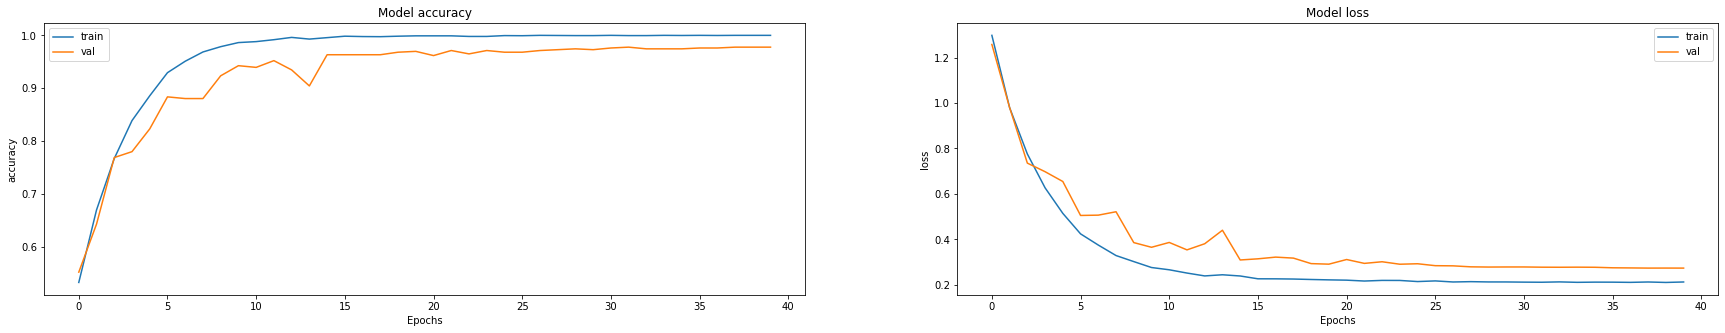

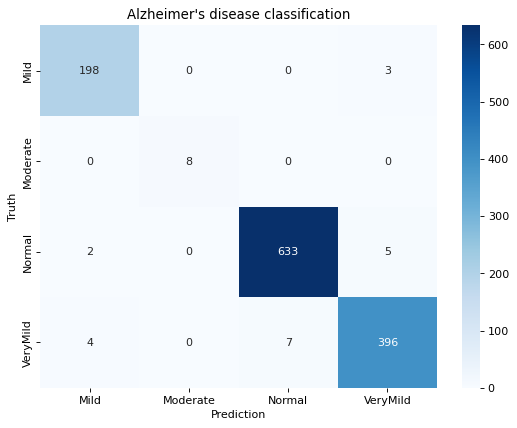

------Weighted-average Evaluation indicators------
Weighted precision 0.9833032080840156
Weighted recall 0.98328025477707
Weighted f1-score 0.983278814914878
------Macro-average Evaluation indicators------
Macro precision 0.9849621887740245
Macro recall 0.9867775249596611
Macro f1-score 0.9858531027366764
------Micro-average Evaluation indicators------
Micro precision 0.98328025477707
Micro recall 0.98328025477707
Micro f1-score 0.98328025477707


In [18]:
reset_keras()#Clear memory to avoid problems
get_result(model_history,model,test_data,test_labels)